In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BatchNorm1d

import ray.cloudpickle as pickle
import ray
from ray import train,tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler

Checking if cuda is available - Highly reccomended to run this code on a cuda enabled GPU

In [ ]:
print('Cuda is available:',torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Running on device:',torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('Running on device:',device)

# Investigating the Training Data

This section explores the key features of our training data for protein secondary structure prediction, but first let's establish some foundational terminology and theory relevant to this task.

**Position-Specific Scoring Matrix (PSSM)**

* This matrix captures the likelihood of observing each amino acid at specific positions within a protein sequence. It's derived from analyzing multiple sequence alignments. 
* In our dataset, the PSSM probabilities are already preprocessed for training, ranging from 0 (no likelihood) to 1 (absolute likelihood).
* In our dataset for each position the primary structure can be one of 20 different amino acids represented by letters.


In [ ]:
quick_vis = pd.read_csv('../data/pssm_csv/test/1A0S_1_P_test.csv')
quick_vis.head()

#### One hot encode or use probabilites from PSSM?
In terms of preprocessing for the nueral network, although one hot encoding of the amino acid could be used, I have chosen to use the raw PSSM data. They both have the same dimensionality, however one hot encoded data contains less information about the amino acids. The model may be able to learn from one hot encoding quicker as it simplifies the data from continuous values between 0-1 to binary outputs for each amino acid. however to achieve the highest scores keeping the information may come out on top.

In [ ]:
global onehotencode
onehotencode = False

In [ ]:
import pandas as pd
def get_sequence_lengths(directory):
    df = pd.read_csv(directory, usecols=['SEQUENCE'])
    return df['SEQUENCE'].apply(len).values

seq_lengths_train = get_sequence_lengths('../data/simplified_seq/seqs_train.csv')
seq_lengths_test = get_sequence_lengths('../data/simplified_seq/seqs_test.csv')

if len(seq_lengths_train) > len(seq_lengths_test):
  padding_length = len(seq_lengths_train) - len(seq_lengths_test)
  padding_values = np.full(padding_length, np.nan)
  seq_lengths_test = np.concatenate((seq_lengths_test, padding_values))
        

sequences_df = pd.DataFrame({'Train':seq_lengths_train, 'Test':seq_lengths_test})

bins = 30
plt.figure(figsize=(16,9))
plt.title('Contrasting Distributions of Sequence Lengths Across Train and Test Data')

sns.histplot(data =sequences_df['Train'],
            bins=bins, 
            kde=True,
            stat='density',
            label='Train',
            legend=True)

sns.histplot(data =sequences_df['Test'],
            bins=bins, 
            kde=True,
            stat='density',
            label='Test',
            legend=True)

plt.xlabel('Sequence Length')
plt.ylabel('Density')
plt.legend()

In [ ]:
plt.figure(figsize=(16,9))
plt.title('Contrasting Distributions of Sequence Lengths Across Train and Test Data')

sns.boxplot(
    data=sequences_df, 
    orient='h',
    legend=True,
)
print('Train max sequence length:',sequences_df['Train'].max())
print('Test max sequence length:',sequences_df['Test'].max())

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('ECDF: Cumulative Distribution of Sequence Lengths')

# ECDF plot using Seaborn's ecdfplot function
sns.ecdfplot(data=sequences_df)  # Changed from 'Train' and 'Test' to 'variable' for automatic labeling

plt.xlabel('Sequence Length')
plt.ylabel('Proportion of Sequences')
plt.legend(title='Data Split')  # Adjusted legend title

plt.show()

#### Analysing at the sequence length distribution
From these visualisations we can observe that the sequence lengths for the training data are often larger than for the test data.

As our input shape to our FCN will have to be able to take in a set max sequence length it may be tempting to remove all training data above a certain threshold to reduce the input size; reducing computation and focusing the model on sequences similar length to the test data. Howver this would cause many issues such as:

* *Loss of Information*:
Long sequences might contain valuable patterns or features that the FCN could learn from. Removing them can limit the model's ability to capture complex relationships in the data.

* *Data Imbalance*: The removed sequences could contain more information on a specific second structure leading to a class imbalance problem, where the model struggles to predict a certain class.

* *Reduced Generalizability*: The FCN might not generalize well to unseen data beyond this competition if it's not trained on a representative distribution of sequence lengths.

#### Using a padding approach to address variable sequence lengths
As this study is not exploring the use of more complex methods such as RNNs we will use padding to deal with the differences in sequence length padding all of the data to the maximum sequence length in our data of 1733.
We can either pad with 0 meaning no amino acids are present or -1 which could be learnt by the model as data not being present.

This will result in a 20 channel (number of different amino acids) by 1733 (max_sequence_length) shape input layer.
* i.e shape (N, 20, max_sequence_length) where N is the batch size


**Protein Secondary Structure**: 

The secondary structure refers to the local folding patterns formed by a protein's amino acid sequence. It's influenced by a combination of factors:
* *Amino Acid Sequence*: The specific sequence of amino acids plays a crucial role in determining the potential secondary structures that can form.
* *Local Interactions*: Nearby amino acids interact with each other, influencing how the protein chain folds in localized regions.
* *Overall Folding Landscape*: The final 3D structure of the protein, including its secondary structures, is influenced by interactions throughout the entire molecule.
* In our data the secondry structure has three posibilites for each position: H = Helix, E = Extended Sheet, C = Coil symbols.

In [ ]:
quick_vis = pd.read_csv('../data/labels/labels_train.csv')
quick_vis.head()

#### Encoding the Secondry Structures
As the secondry structure is given as characters we need to encode it as the model can only understand numerical data. Using One hot encoding we can both encode and decode second structure data.
These functions assume that the output will be as [0 0 0 1], [1 0 0 0] corresponding to each sequence position. You might notice that there are 4 classes here but there are only 3 second structures to predict from. I have added an extra class that means the sequence is over and is mapped to ' '. I have also added max sequence length so that the code could be used for shorter sequences truncating the labels.

In [ ]:
def one_hot_encode_sequence(sequence, max_sequence_length):
    encoding = {'H': [1,0,0,0], 'E': [0,1,0,0], 'C': [0,0,1,0], ' ': [0,0,0,1]}
    encoded_sequence = []

    if len(sequence) > max_sequence_length:
        sequence = sequence[:max_sequence_length]
        
    for char in sequence:
        encoded_sequence.extend(encoding[char])
    
        
    num_blanks = max_sequence_length - len(sequence)
    encoded_sequence.extend([0, 0, 0, 1] * num_blanks)
    
    
    
    return torch.tensor(encoded_sequence, dtype=torch.float32).reshape(-1,4)


def decode_output(encoded_sequence, threshold=0.5):
    # the encoded_sequence is a N x 4 x L torch.tensor
    
    sequence = ''
    
    for i in range(encoded_sequence.size(1)):  
        
        if encoded_sequence[0,i,0] >= threshold:
            sequence += 'H'
        elif encoded_sequence[0, i, 1] >= threshold:
            sequence += 'E'
        elif encoded_sequence[0, i, 2] >= threshold:
            sequence += 'C'
        else:
            sequence += ' '
    return sequence


test_string = 'HCEC HCCCEC H'
test_encoded = one_hot_encode_sequence(test_string, 7)
print('Original:', test_string)
print('Encoded:', test_encoded)
print('Encoded shape:', test_encoded.shape)
test_encoded.unsqueeze_(0)
print('Decoded:', decode_output(test_encoded))

**Convolutional Neural Networks (CNNs) and Local Interactions**:

 As CNNs are well-suited to capture local sequence features. By applying convolutional layers, the model can analyze patterns within the PSSM data, aiding in predicting the secondary structure based on these local interactions within the protein sequence.
 
 In this study a fully convolutional nueral network (FCN) will be used to predict the secondry structure. We will now create a dataloader for our network given the information we have learnt.


# Creating a Custom pytorch PSSM DataSet and DataLoaders

In [ ]:
class PSSM(Dataset):
    """Position-Specific Scoring Matrix (PSSM) Dataset"""

    def __init__(self, pssm_root_dir, sec_struct_file_path,tensor_files_dir,max_sequence_length=1733, transform=None):
        """
        Args:
            pssm_root_dir (string): Directory with all the protein PSSM data.
            sec_struct_root_dir (string): Directory with all the protein secondary structure data. 
            transform (callable, optional): Optional transform to be applied on a sample. (not used here)           
        """
        self.pssm_root_dir = pssm_root_dir
        self.sec_struct_file_path = sec_struct_file_path
        self.tensor_files_dir = tensor_files_dir
        os.makedirs(self.tensor_files_dir, exist_ok=True)
        self.max_sequence_length = max_sequence_length
        self.transform = transform 
        
        self.file_list = [file for file in os.listdir(pssm_root_dir) if file.endswith('.csv')]
        if self.sec_struct_file_path is not None:
            self.sec_struct_data = pd.read_csv(self.sec_struct_file_path)


    def preprocess_and_save_tensors(self): # Depending on system requirements may be memory intensive to run
        
        for file_name in self.file_list:
            
            pssm_csv_file = os.path.join(self.pssm_root_dir, file_name)
            pbd_id = os.path.splitext(file_name)[0]

            pssm_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}.pt")
            sec_struct_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}_sec_struct.pt")
            
      
            
            if not os.path.exists(pssm_tensor_file_path):
                pssm_data = pd.read_csv(pssm_csv_file)
                pssm_data = pssm_data.drop(columns=['RES_NUM', 'AMINO_ACID'], axis=1)
                if onehotencode:
                    pssm_data = pssm_data.eq(pssm_data.max(axis=1), axis=0).astype(int)

                
                num_zeros = 0
                if len(pssm_data) > self.max_sequence_length:
                    pssm_data = pssm_data[:self.max_sequence_length]
                else:               
                    num_zeros = self.max_sequence_length - len(pssm_data)
                if num_zeros > 0:
                    df_zeros = pd.DataFrame(0, index=range(num_zeros), columns=pssm_data.columns)
                    pssm_data = pd.concat([pssm_data, df_zeros], ignore_index=True)
                
                pssm_data = pssm_data.T.to_numpy()
                pssm_data = torch.tensor(pssm_data, dtype=torch.float32)

                torch.save(pssm_data, pssm_tensor_file_path)
            
                
            elif self.sec_struct_file_path is not None:
                if not os.path.exists(sec_struct_tensor_file_path):

                        
                    sec_struc_value = self.sec_struct_data.loc[self.sec_struct_data['PDB_ID'] == '_'.join(pbd_id.split('_')[:-1]), 'SEC_STRUCT'].values[0]
                    encoded_sec_struc = one_hot_encode_sequence(sec_struc_value, self.max_sequence_length)

                    torch.save(encoded_sec_struc, sec_struct_tensor_file_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        pbd_id = os.path.splitext(file_name)[0]
        pbd_id = ''.join(pbd_id)
        tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}.pt")
        pssm_data = torch.load(tensor_file_path)
        input = pssm_data

        
        if self.sec_struct_file_path is not None:

            sec_struct_tensor_file_path = os.path.join(self.tensor_files_dir, f"{pbd_id}_sec_struct.pt")
            encoded_sec_struc = torch.load(sec_struct_tensor_file_path) # form like [[0, 0, 0, 1], [0, 1, 0, 0]...]
            target = torch.argmax(encoded_sec_struc,dim=1) # form like [3, 1, ....]
            return input, target
        
        else:
            return pbd_id,input

#### Create datasets based on the train and test data
Preprocess and save tensor files if this has not already been done

In [83]:
global maximum_sequence_length
maximum_sequence_length = 1733

In [ ]:
train_val_dataset = PSSM(pssm_root_dir='../data/pssm_csv/train',
                      sec_struct_file_path='../data/labels/labels_train.csv',
                      tensor_files_dir='/home/jamiemilsom/Documents/PSSM_CNN/data/pssm_tensor/',
                      max_sequence_length=maximum_sequence_length)

test_dataset = PSSM(pssm_root_dir='../data/pssm_csv/test',
                      sec_struct_file_path=None,
                      tensor_files_dir='/home/jamiemilsom/Documents/PSSM_CNN/data/pssm_tensor/',
                      max_sequence_length=maximum_sequence_length)

test_dataset.preprocess_and_save_tensors()
train_val_dataset.preprocess_and_save_tensors()

#### Create Dataloaders based on the custom datasets

As the train dataset is relatively large I am using a train val split of 70% rather than cross validation

In [ ]:
train_size = int(0.70 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset,batch_size=64, shuffle=False)
train_val_dataloader = DataLoader(train_val_dataset, batch_size=64, shuffle=False) # for training the model after hyperparameter tuning

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Testing the dataloaders

In [ ]:
for input, target in train_dataloader:
    print(input.shape,target.shape)
    break


In [ ]:
for pbd_id, input in test_dataloader:
    print(input.shape)
    break

# Creating the FCN Structure

In [ ]:
pssm_input_channels = 20

class ProteinStructurePredictor(nn.Module):
    def __init__(self,k1,k2,k3,k4,k5,k6,k7,c1,c2,c3,c4,c5,c6,dropout_rate,num_classes=4): # k = kernel sizes, c = channels,l = linear layers
        super(ProteinStructurePredictor, self).__init__()
        self.num_classes = num_classes
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=pssm_input_channels, out_channels=c1, kernel_size=k1, padding=((k1-1)//2)), 
            nn.BatchNorm1d(c1),
            nn.ReLU(),
            nn.Conv1d(c1, c2, kernel_size=k2, padding=((k2-1)//2)),
            nn.BatchNorm1d(c2),
            nn.ReLU(),
            nn.Dropout(dropout_rate), 
            nn.Conv1d(c2, c3, kernel_size=k3, padding=((k3-1)//2)),
            nn.BatchNorm1d(c3),
            nn.ReLU(),
            nn.Conv1d(c3, c4, kernel_size=k4, padding=((k4-1)//2)),
            nn.BatchNorm1d(c4),
            nn.ReLU(),
            nn.Dropout(dropout_rate), 
            nn.Conv1d(c4, c5, kernel_size=k5, padding=((k5-1)//2)),
            nn.BatchNorm1d(c5),
            nn.ReLU(),
            nn.Conv1d(c5, c6, kernel_size=k6, padding=((k6-1)//2)),
            nn.BatchNorm1d(c6),
            nn.ReLU(),
            nn.Conv1d(c6, self.num_classes, kernel_size=k7, padding=((k7-1)//2)),


        )


    def forward(self, x):
        
        x = self.conv_layers(x)
        x = x.unfold(dimension=1,size=4,step=maximum_sequence_length)
        x = x.reshape(-1,4)
        return x



In [ ]:
model = ProteinStructurePredictor(k1 = 3, k2 = 3, k3 = 5, k4 = 5, k5 = 7, k6= 7,k7=3, c1 = 64, c2 = 32,c3 = 16, c4 = 16, c5 =16 ,c6=8, dropout_rate=0.1,  num_classes=4)  
loss_fn = nn.CrossEntropyLoss()
optimizer_conv = torch.optim.Adam(model.parameters())#, weight_decay=weight_decay)

print(model)

In [ ]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)
    for epoch in range(num_epochs):
        
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1)
            

            outputs = model(inputs)       
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()


            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)

            total_train += labels.size(0) - (labels == 3).sum().item()
            
            correct_train += torch.sum((predicted == labels)).item() - (labels == 3).sum().item()

        avg_train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).view(-1)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)

                total_val += labels.size(0) - (labels == 3).sum().item()
                correct_val += torch.sum((predicted == labels)).item() - (labels == 3).sum().item()

        avg_val_loss = val_loss / len(val_dataloader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer_conv, num_epochs=5)

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

# Raytune

In [ ]:
context = ray.init()
print(context.dashboard_url)

In [ ]:
def train_model_raytune(config):

    model = ProteinStructurePredictor(k1 = config['k1'], k2 = config['k2'], k3 = config['k3'], k4 = config['k4'], k5 = config['k5'], k6= config['k6'], k7 = config['k7'],
                                      c1 = config['c1'], c2 = config['c2'],c3 = config['c3'], c4 = config['c4'], c5 = config['c5'],c6 = config['c6'],dropout_rate=config['dropout_rate'], num_classes=4)  


    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=config["weight_decay"])

    checkpoint = train.get_checkpoint()

    if checkpoint:
        with train.get_checkpoint().as_directory() as checkpoint_dir:
          with open(os.path.join(checkpoint_dir, 'data.pkl'), 'rb') as fp:
            checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            model.load_state_dict(checkpoint_state["model_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    train_subset, val_subset = train_dataset, val_dataset


    trainloader = torch.utils.data.DataLoader(
        train_subset, batch_size=int(config["batch_size"]), shuffle=False, num_workers=8
    )
    valloader = torch.utils.data.DataLoader(
        val_subset, batch_size=int(config["batch_size"]), shuffle=False, num_workers=8
    )
    max_accuracy = 0

    for epoch in range(start_epoch, start_epoch + config["num_epochs"]):
        running_loss = 0.0
        epoch_steps = 0
        total_train = 0
        correct_train = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device).view(-1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total_train += labels.size(0) - (labels == 3).sum().item()
            correct_train += torch.sum((predicted == labels)).item() - (labels == 3).sum().item()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item() * inputs.size(0) # maybe change this to just loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0
                

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device).view(-1)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)- (labels == 3).sum().item()
                correct += torch.sum((predicted == labels)).item() - (labels == 3).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy() * inputs.size(0)
                val_steps += 1


        checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

        """
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            with open(os.path.join(checkpoint_dir, 'data.pkl'), 'wb') as fp:
                pickle.dump(checkpoint_data, fp)                
        
                
        checkpoint = Checkpoint.from_directory(checkpoint_dir)
        """
        if correct / total > max_accuracy:
            max_accuracy = correct / total
        train.report(
              {"epochs":epoch,"loss": val_loss / val_steps, "test accuracy":correct_train/total_train,"val accuracy": correct / total, 'max accuracy':max_accuracy})#,
              #checkpoint=checkpoint,
          #)
    print("Finished Training")


In [ ]:
def test_accuracy(model, device=device):
    trainset, testset = test_dataset, val_dataset

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=32, shuffle=False, num_workers=2
    )

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            input, labels = data
            input, labels = input.to(device), labels.to(device)
            outputs = model(input)
            
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0) - (labels == 3).sum().item()
            correct += torch.sum((predicted == labels)).item() - (labels == 3).sum().item()

    return correct / total

In [67]:
def main(num_samples=10, max_num_epochs=50, gpus_per_trial=1):

    config = {
        'k1': tune.choice([3,5,7,9,15,25,49]),
        'k2': tune.choice([3,5,7,9,15,25,49]),
        'k3': tune.choice([3,5,7,9,15,25,49]),
        'k4': tune.choice([3,5,7,9,15,25,49]),
        'k5': tune.choice([3,5,7,9,15,25,49]),
        'k6': tune.choice([3,5,7,9,15,25,49]),
        'k7': tune.choice([3,5,7,9,15,25,49]),


        'c1': tune.choice([4,8,16,32,64]),
        'c2': tune.choice([4,8,16,32,64]),
        'c3': tune.choice([4,8,16,32,64]),
        'c4': tune.choice([4,8,16,32,64]),
        'c5': tune.choice([4,8,16,32,64]),
        'c6': tune.choice([4,8,16,32,64]),
        "batch_size": tune.choice([64]),
        "num_epochs": max_num_epochs,
        'dropout_rate': tune.uniform(0,0.3),
        "weight_decay": tune.loguniform(0.001,0.00001)
    }
    scheduler = ASHAScheduler(
        metric="val accuracy",
        mode="max",
        max_t=max_num_epochs,
        grace_period=10,
        reduction_factor=2,
    )

    result = tune.run(
        train_model_raytune,
        resources_per_trial={"cpu": 4, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        max_concurrent_trials=8,
    )
    
    """
    best_trial = result.get_best_trial("accuracy", "max", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

    best_trained_model = ProteinStructurePredictor(best_trial.config["dropout_prob"],best_trial.config["k1"],best_trial.config["k2"],best_trial.config["k3"],best_trial.config["l1"],best_trial.config["c1"],best_trial.config["c2"],best_trial.config["c3"],num_classes=4)
    return best_trained_model
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint = best_trial.checkpoint;

    if best_checkpoint:
        with best_checkpoint.as_directory() as checkpoint_dir:
          with open(os.path.join(checkpoint_dir, 'data.pkl'), 'rb') as fp:
            best_checkpoint_data = pickle.load(fp)
            best_trained_model.load_state_dict(best_checkpoint_data["model_state_dict"])
            test_acc = test_accuracy(best_trained_model, device)
            print("Best trial test set accuracy: {}".format(test_acc))

    """

if __name__ == "__main__":

    best_trained_model = main(num_samples=800, max_num_epochs=20, gpus_per_trial=1/4)


2024-03-11 01:18:34,399	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,epochs,loss,max accuracy,test accuracy,val accuracy
train_model_raytune_47bb2_00000,9,5.51279,0.763411,0.76758,0.763411
train_model_raytune_47bb2_00001,9,5.72706,0.760916,0.767387,0.760916
train_model_raytune_47bb2_00002,19,5.14586,0.77694,0.78414,0.77694
train_model_raytune_47bb2_00003,19,5.12877,0.777046,0.784745,0.777046
train_model_raytune_47bb2_00004,19,5.06242,0.779126,0.787814,0.779126
train_model_raytune_47bb2_00005,19,5.14222,0.77699,0.787425,0.776733
train_model_raytune_47bb2_00006,19,5.11384,0.777063,0.785881,0.777063
train_model_raytune_47bb2_00007,9,5.37209,0.767508,0.775055,0.767508
train_model_raytune_47bb2_00008,9,5.53011,0.765868,0.773053,0.765868
train_model_raytune_47bb2_00009,9,5.64475,0.753131,0.757845,0.753131


2024-03-11 10:12:41,133	INFO tune.py:1042 -- Total run time: 32046.73 seconds (32046.39 seconds for the tuning loop).


# Creating the final submission

batch_size	c1	c2	c3	c4	c5	c6	dropout_rate	k1	k2	k3	k4	k5	k6	k7	weight_decay	iter	test accuracy
64	32	32	32	32	16	16	0.02786	3	7	5	7	25	15	5	0.000284	20	0.799617

Epoch [1/8], Train Loss: 0.7233, Train Acc: 0.5245, Val Loss: 0.2137, Val Acc: 0.7360
Epoch [2/8], Train Loss: 0.1317, Train Acc: 0.7592, Val Loss: 0.1015, Val Acc: 0.7706
Epoch [3/8], Train Loss: 0.0912, Train Acc: 0.7722, Val Loss: 0.0853, Val Acc: 0.7772
Epoch [4/8], Train Loss: 0.0845, Train Acc: 0.7783, Val Loss: 0.0825, Val Acc: 0.7806
Epoch [5/8], Train Loss: 0.0815, Train Acc: 0.7822, Val Loss: 0.0805, Val Acc: 0.7837
Epoch [6/8], Train Loss: 0.0799, Train Acc: 0.7848, Val Loss: 0.0783, Val Acc: 0.7887
Epoch [7/8], Train Loss: 0.0786, Train Acc: 0.7872, Val Loss: 0.0775, Val Acc: 0.7896
Epoch [8/8], Train Loss: 0.0777, Train Acc: 0.7893, Val Loss: 0.0774, Val Acc: 0.7895


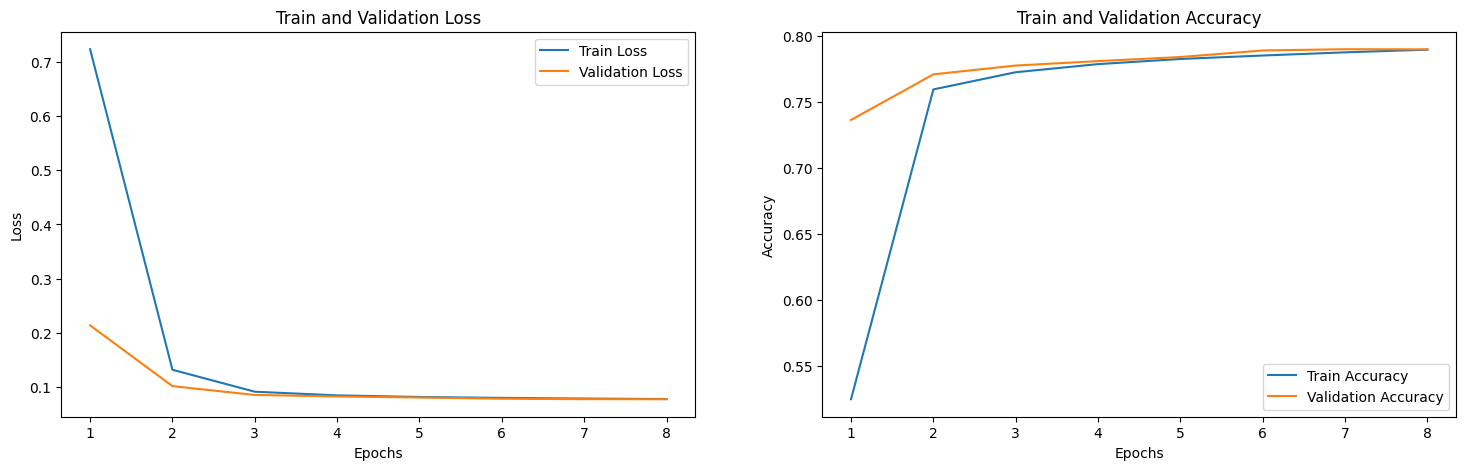

In [71]:
best_trained_model = ProteinStructurePredictor(k1=3,k2=7,k3=5,k4=7,k5=25,k6=15,k7=5,c1=32,c2=32,c3=32,c4=32,c5=16,c6=16,dropout_rate=0.02786)
optimizer_conv = torch.optim.Adam(best_trained_model.parameters(), weight_decay=0.000284)
train_losses, val_losses, train_accuracies, val_accuracies = train_model(best_trained_model, train_val_dataloader, val_dataloader,loss_fn,optimizer_conv,num_epochs=8)
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

In [72]:
all_outputs = []
all_pbids = []

model.eval()
model.to(device)
val_loss = 0.0
correct_val = 0
total_val = 0
with torch.no_grad():
    for pbid, inputs in test_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_pbids.extend(pbid)
        all_outputs.append(outputs)
all_outputs_tensor = torch.cat(all_outputs, dim=0)

In [78]:
def unencode_output(encoded_sequence, threshold=0.5):
    # the encoded_sequence is a N X L X 4 torch.tensor
    
    sequence = ''
    
    for i in range(encoded_sequence.size(0)):  
        outputs = encoded_sequence[i,:]    
        _, predicted = torch.max(outputs, 0)
        if predicted == 0:
            sequence += 'H'
        elif predicted == 1:
            sequence += 'E'
        elif predicted == 2:
            sequence += 'C'
        else:
            sequence += 'C'
    return sequence

In [79]:
def count_rows_in_file(file_path):
    with open(file_path, 'r') as f:
        # Count the number of lines in the file
        count = sum(1 for line in f)
    return count

In [80]:
def create_submission(pbids, output_tensors, output_file):
    with open(output_file, 'w') as f:
        f.write("ID,STRUCTURE\n")
        for i, pbid in enumerate(pbids):
            output = output_tensors[maximum_sequence_length * i:maximum_sequence_length * (i+2),:]
            sequence = unencode_output(output)

            for j in range(count_rows_in_file('../data/pssm_csv/test/' + pbid + '.csv') - 1):
                f.write(f"{'_'.join(pbid.split('_')[:-1])}_{j+1},{sequence[j]}\n")


output_file = "submission.csv"
create_submission(all_pbids, all_outputs_tensor.cpu(), output_file)

In [81]:
submission_file = "submission.csv"
num_rows = count_rows_in_file(submission_file)
print("Number of rows in the submission file:", num_rows)


Number of rows in the submission file: 43162


STRUCTURE
C    21191
H    14105
E     7865
Name: count, dtype: int64


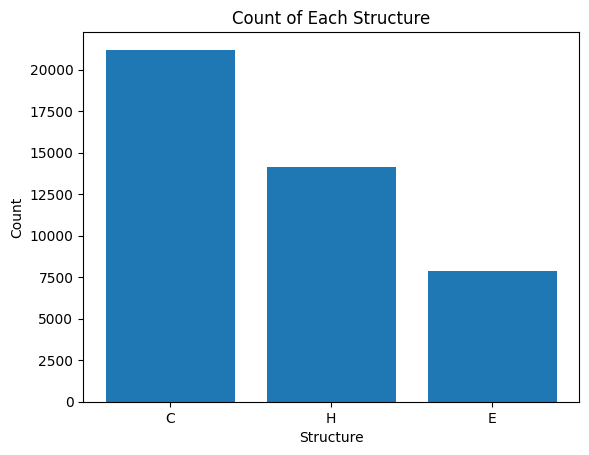

In [82]:
submission = pd.read_csv('submission.csv')
structure_counts = submission['STRUCTURE'].value_counts()
print(structure_counts)
plt.bar(structure_counts.index, structure_counts.values)
plt.xlabel('Structure')
plt.ylabel('Count')
plt.title('Count of Each Structure')
plt.show()